Graph with 50 nodes and 580 edges
{0: 0.0137858425139456, 1: 0.010682054970395307, 2: 0.00750384295088361, 3: 0.004859892152671106, 4: 0.005578499886584963, 5: 0.012855044874596114, 6: 0.008675019843335855, 7: 0.013590955775197892, 8: 0.021822443351416785, 9: 0.005316333696929356, 10: 0.007407792779408531, 11: 0.002865060892383663, 12: 0.006473793711682288, 13: 0.008779835522901172, 14: 0.011081361065466552, 15: 0.008462250701876816, 16: 0.01205447919933056, 17: 0.011341823189160808, 18: 0.010999751752796392, 19: 0.006537817216463675, 20: 0.017181325712336798, 21: 0.01585087423320743, 22: 0.011172886344073237, 23: 0.013989065069595963, 24: 0.009358051741123388, 25: 0.017208715714729962, 26: 0.007783924213719816, 27: 0.012701034006793153, 28: 0.006721184663348372, 29: 0.01128382098994028, 30: 0.01729282057785169, 31: 0.022350824918332186, 32: 0.005298410101811726, 33: 0.013566821163708604, 34: 0.008848645704374838, 35: 0.006209538547967341, 36: 0.007923778379822641, 37: 0.00479896902939

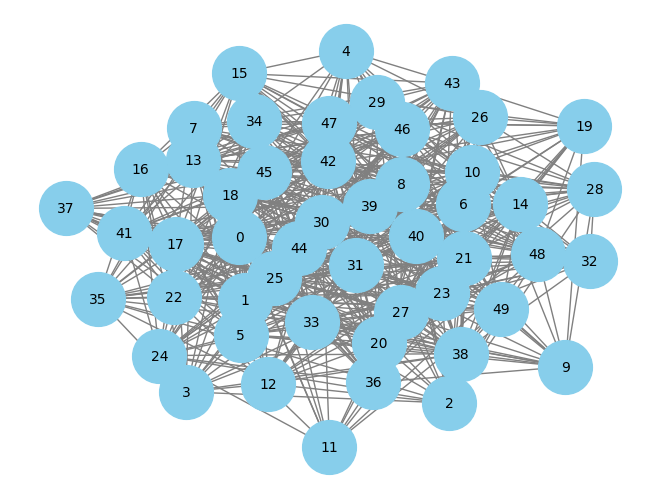

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G=nx.erdos_renyi_graph(50,0.5)
b=nx.betweenness_centrality(G)
print(G)
print(b)
# Draw the graph
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, node_color='skyblue', node_size=1500, font_size=10, edge_color='gray')

# Display the plot
plt.show()

Betweenness centrality: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0}


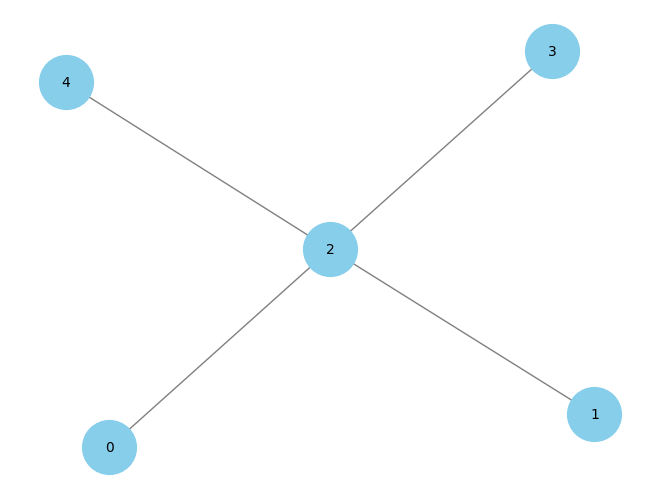

In [2]:
import random
import networkx as nx
from collections import deque, defaultdict
import matplotlib.pyplot as plt

def betweenness_centrality(graph, normalized=True):
    """
    Compute betweenness centrality for all nodes in an unweighted graph
    using Brandes' algorithm.

    Parameters
    ----------
    graph : dict
        Graph represented as adjacency list {node: [neighbors]}.
    normalized : bool
        If True, normalize betweenness values.

    Returns
    -------
    betweenness : dict
        Dictionary mapping nodes to betweenness centrality value.
    """
    betweenness = dict.fromkeys(graph, 0.0)  # initialize centrality

    for s in graph:
        # Single-source shortest paths
        stack = []
        pred = {w: [] for w in graph}  # predecessors
        sigma = dict.fromkeys(graph, 0.0)  # number of shortest paths
        dist = dict.fromkeys(graph, -1)    # distances
        sigma[s] = 1.0
        dist[s] = 0

        # BFS
        queue = deque([s])
        while queue:
            v = queue.popleft()
            stack.append(v)
            for w in graph[v]:
                # path discovery
                if dist[w] < 0:
                    queue.append(w)
                    dist[w] = dist[v] + 1
                # path counting
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)

        # Accumulation
        delta = dict.fromkeys(graph, 0.0)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                delta_v = (sigma[v] / sigma[w]) * (1 + delta[w])
                delta[v] += delta_v
            if w != s:
                betweenness[w] += delta[w]

    # Normalization
    if normalized:
        scale = 1 / ((len(graph) - 1) * (len(graph) - 2))
        for v in betweenness:
            betweenness[v] *= scale

    return betweenness



# Create a graph
G=nx.erdos_renyi_graph(5,0.5)
# Compute betweenness centrality
bc = betweenness_centrality(G, normalized=True)
print("Betweenness centrality:", bc)

# Draw the graph
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, node_color='skyblue', node_size=1500, font_size=10, edge_color='gray')

# Display the plot
plt.show()



In [3]:
# hybrid_vs_brandes.py
# Run with: python hybrid_vs_brandes.py

from collections import deque
import random
import math

# --------------- Graph utils ----------------

def erdos_renyi_graph(n, p, seed=None):
    if seed is not None:
        random.seed(seed)
    graph = {i: [] for i in range(n)}
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                graph[i].append(j)
                graph[j].append(i)
    return graph

# --------------- Brandes (exact) --------------

def brandes_betweenness(graph):
    """Exact Brandes algorithm for unweighted graphs."""
    betweenness = dict.fromkeys(graph, 0.0)
    for s in graph:
        # single-source
        stack = []
        pred = {w: [] for w in graph}
        sigma = dict.fromkeys(graph, 0.0)
        dist = dict.fromkeys(graph, -1)
        sigma[s] = 1.0
        dist[s] = 0
        queue = deque([s])
        while queue:
            v = queue.popleft()
            stack.append(v)
            for w in graph[v]:
                if dist[w] < 0:
                    queue.append(w)
                    dist[w] = dist[v] + 1
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        # accumulation
        delta = dict.fromkeys(graph, 0.0)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] != 0:
                    delta_v = (sigma[v] / sigma[w]) * (1 + delta[w])
                    delta[v] += delta_v
            if w != s:
                betweenness[w] += delta[w]
    # normalization (undirected)
    n = len(graph)
    if n > 2:
        scale = 1.0 / ((n - 1) * (n - 2))
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness

# --------------- Hybrid estimator --------------

def degree_filter(graph, percentile=50):
    degrees = {v: len(graph[v]) for v in graph}
    if not degrees:
        return set()
    sorted_deg = sorted(degrees.values())
    idx = int(len(sorted_deg) * percentile / 100)
    idx = max(0, min(len(sorted_deg)-1, idx))
    threshold = sorted_deg[idx]
    return set(v for v,d in degrees.items() if d >= threshold)

def quantum_sampling(S):
    """Simulated amplitude amplification: reduce S -> ceil(sqrt(S))."""
    return max(1, int(math.ceil(math.sqrt(max(1, S)))))

def bfs_shortest_paths(graph, source):
    stack, pred = [], {w: [] for w in graph}
    sigma = dict.fromkeys(graph, 0.0)
    dist = dict.fromkeys(graph, -1)
    sigma[source] = 1.0
    dist[source] = 0
    queue = deque([source])
    while queue:
        v = queue.popleft()
        stack.append(v)
        for w in graph[v]:
            if dist[w] < 0:
                queue.append(w)
                dist[w] = dist[v] + 1
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                pred[w].append(v)
    return stack, pred, sigma, dist

def hybrid_betweenness(graph, percentile=50, sample_fraction=0.2, seed=None):
    """Hybrid estimator: degree filter + quantum-inspired sampling + restricted accumulation."""
    if seed is not None:
        random.seed(seed)
    n = len(graph)
    nodes = list(graph.keys())

    # Preprocessing: cheap degree filter (O(V+E))
    candidates = degree_filter(graph, percentile)

    # Sampling: classical baseline S = fraction of nodes (e.g., 20%)
    classical_S = max(1, int(math.ceil(sample_fraction * n)))
    S = quantum_sampling(classical_S)  # simulated reduced sample count
    sources = random.sample(nodes, min(S, n))

    # Accumulate only for candidates
    bc = dict.fromkeys(nodes, 0.0)
    for s in sources:
        stack, pred, sigma, dist = bfs_shortest_paths(graph, s)
        delta = dict.fromkeys(graph, 0.0)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] != 0:
                    delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
            if w != s and w in candidates:
                bc[w] += delta[w]

    # scale to account for sampling
    factor = float(n) / max(1, len(sources))
    for v in bc:
        bc[v] *= factor

    # normalization
    if n > 2:
        scale = 1.0 / ((n - 1) * (n - 2))
        for v in bc:
            bc[v] *= scale
    return bc, candidates, sources

# --------------- Comparison metrics --------------

def top_k(dic, k=10):
    return sorted(dic.items(), key=lambda x: x[1], reverse=True)[:k]

def top_k_overlap(exact, est, k=10):
    exact_top = set(v for v,_ in top_k(exact,k))
    est_top = set(v for v,_ in top_k(est,k))
    return len(exact_top & est_top), exact_top, est_top

def spearman_rank_corr(exact, est):
    """Simple Spearman rank correlation (handles ties by average rank)."""
    n = len(exact)
    # create ranks: highest value -> rank 1
    def rank_map(d):
        items = sorted(d.items(), key=lambda x: (-x[1], x[0]))
        ranks = {}
        i = 1
        while i <= len(items):
            # handle ties
            j = i
            while j <= len(items) and items[j-1][1] == items[i-1][1]:
                j += 1
            avg_rank = (i + (j-1)) / 2.0
            for t in range(i-1, j-1):
                ranks[items[t][0]] = avg_rank
            i = j
        return ranks
    r_exact = rank_map(exact)
    r_est = rank_map(est)
    # compute Pearson correlation of ranks
    mean_rx = sum(r_exact.values()) / n
    mean_ry = sum(r_est.values()) / n
    num = sum((r_exact[v]-mean_rx)*(r_est[v]-mean_ry) for v in exact)
    denx = math.sqrt(sum((r_exact[v]-mean_rx)**2 for v in exact))
    deny = math.sqrt(sum((r_est[v]-mean_ry)**2 for v in exact))
    if denx == 0 or deny == 0:
        return 0.0
    return num / (denx * deny)

def l1_error(exact, est):
    return sum(abs(exact[v] - est.get(v, 0.0)) for v in exact)

# --------------- Small experiment --------------

def compare(n=100, p=0.05, seed=123):
    G = erdos_renyi_graph(n, p, seed=seed)
    exact = brandes_betweenness(G)
    est, candidates, sources = hybrid_betweenness(G, percentile=50, sample_fraction=0.2, seed=seed+1)

    print(f"Graph: n={n}, p={p}")
    print(f"Candidates (count): {len(candidates)}")
    print(f"Sources sampled (quantum reduced): {len(sources)} -> {sources}\n")

    # Top-10 comparison
    k = 10
    overlap, exact_top, est_top = top_k_overlap(exact, est, k=k)
    print(f"Top-{k} overlap: {overlap}/{k}")
    print("Exact top-10:", top_k(exact,k))
    print("Hybrid top-10:", top_k(est,k))
    print()

    # Spearman
    s_corr = spearman_rank_corr(exact, est)
    print(f"Spearman rank correlation between exact & hybrid ranks: {s_corr:.4f}")

    # L1 error
    err = l1_error(exact, est)
    print(f"L1 error (sum abs diff): {err:.6f}")

if __name__ == "__main__":
    compare(n=120, p=0.04, seed=2025)


Graph: n=120, p=0.04
Candidates (count): 66
Sources sampled (quantum reduced): 5 -> [15, 40, 64, 65, 82]

Top-10 overlap: 3/10
Exact top-10: [(49, 0.07217785891911008), (6, 0.05450966674249382), (72, 0.05080527677989053), (29, 0.05022774337423271), (93, 0.0470400955870894), (31, 0.045879856332272366), (59, 0.044042239626848), (11, 0.04343335016576742), (101, 0.04298183372011515), (87, 0.0426012483484468)]
Hybrid top-10: [(101, 0.09933762766692548), (56, 0.09256023376519032), (80, 0.07531471519507411), (78, 0.06538945079039082), (93, 0.0600081065969116), (17, 0.05847285696310052), (19, 0.05406486880635862), (33, 0.052655021947145574), (102, 0.050501556554825314), (72, 0.050464931735406025)]

Spearman rank correlation between exact & hybrid ranks: 0.8246
L1 error (sum abs diff): 1.399846


# Between Centrality (Standard Code)

In [4]:
!pip install qiskit networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import networkx as nx
G = nx.read_edgelist('/content/gdrive/My Drive/Colab Notebooks/CA-CondMat.txt', create_using=nx.Graph())

print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
no_of_triangles = nx.triangles(G)
b=nx.betweenness_centrality(G)
#print(sum(no_of_triangles.values())/3)
def sort_dict(d, reverse = False):
  return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

deg_sort1 = sort_dict(b, True)
#print(deg_sort1)
p=deg_sort1.keys()
list1=list(deg_sort1.keys())
#print(list1)
#print(deg_sort1.values())
list3=list(deg_sort1.values())
#print(list3)

23133
93497


In [2]:
import networkx as nx
import time
start = time.time()
G = nx.read_edgelist('/content/gdrive/My Drive/Colab Notebooks/CA-CondMat.txt', create_using=nx.Graph())

print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
no_of_triangles = nx.triangles(G)
b=nx.betweenness_centrality(G)
#print(sum(no_of_triangles.values())/3)
def sort_dict(d, reverse = False):
  return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

deg_sort1 = sort_dict(b, True)
#print(deg_sort1)
p=deg_sort1.keys()
list1=list(deg_sort1.keys())
print(list1)
print(deg_sort1.values())
list3=list(deg_sort1.values())
print(list3)
stop = time.time()
print("Execution Time = ", stop-start)

23133
93497
['73647', '52658', '101355', '22757', '101425', '46269', '78667', '46016', '56672', '15439', '8536', '26075', '97632', '101191', '91392', '107009', '15345', '9991', '52364', '15113', '83197', '97788', '84209', '96866', '35171', '31762', '106876', '38468', '33410', '66800', '22987', '45942', '28575', '12915', '1895', '46066', '95940', '52421', '42316', '101472', '41266', '66908', '35688', '91541', '52726', '30365', '53880', '905', '96395', '72331', '80915', '46144', '61271', '73122', '71461', '18654', '64845', '26750', '66863', '2716', '86764', '60662', '55595', '29380', '90690', '60251', '88748', '43683', '1764', '54354', '23127', '85840', '36740', '30488', '57070', '52228', '83259', '83824', '52472', '53994', '26002', '53906', '95372', '5215', '57478', '62113', '11063', '46805', '57036', '53856', '73904', '72044', '55210', '85266', '52449', '40271', '52287', '15290', '4750', '74869', '36435', '21181', '32438', '62327', '78952', '83876', '42792', '31208', '35142', '93429', 

#HQCBC

In [3]:
!pip install qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00


In [4]:
import math
import random
import numpy as np
import networkx as nx
import time

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XGate
from qiskit.circuit.library import UnitaryGate

In [5]:
start = time.time()
# ----------------------
# Helper: classical preprocessing
# ----------------------
def build_candidate_set(G: nx.Graph, degree_threshold: int = None, top_k: int = None):
    """
    Build candidate set C either by threshold k (degree >= degree_threshold)
    or top_k highest-degree nodes (if top_k provided).
    """
    degrees = dict(G.degree())
    if degree_threshold is not None:
        C = [v for v, d in degrees.items() if d >= degree_threshold]
    elif top_k is not None:
        # sort by degree descending and take top_k
        C = sorted(degrees.keys(), key=lambda v: degrees[v], reverse=True)[:top_k]
    else:
        # default: all nodes
        C = list(G.nodes())
    return list(C), degrees

# ----------------------
# Quantum-inspired: amplitude amplification to pick nodes from candidate set
# ----------------------
def _build_oracle_matrix(num_basis: int, marked_indices):
    """
    Build a diagonal oracle matrix U_w of size 2^n x 2^n that flips the phase
    of marked basis states (indices in [0, num_basis-1] matching marked_indices).
    If 2^n > num_basis, the remaining states are treated as unmarked.
    """
    dim = 1 << int(math.ceil(math.log2(num_basis)))
    mat = np.eye(dim, dtype=complex)
    for idx in marked_indices:
        mat[idx, idx] = -1.0
    return mat

def _diffusion_matrix(n_qubits):
    """
    Standard Grover diffusion operator on 2^n dimension.
    """
    dim = 1 << n_qubits
    # reflection about uniform superposition: 2|s><s| - I
    s = np.ones((dim, dim)) / dim
    return 2 * s - np.eye(dim)

def quantum_sample_one(num_items, marked_set, shots=1024):
    """
    Run a small Grover-style amplitude amplification on num_items states,
    marking indices in 'marked_set' and return one sampled index (classical int).
    Implementation details:
      - We build explicit oracle and diffusion matrices (works for small num_items).
      - We run a small number of Grover iterations (floor(pi/4 * sqrt(N/M))).
    """
    if len(marked_set) == 0:
        raise ValueError("marked_set is empty")
    # choose number of qubits
    n_qubits = int(math.ceil(math.log2(num_items)))
    dim = 1 << n_qubits

    # Oracle matrix on full dim (if dim > num_items the extra states are unmarked)
    oracle_mat = _build_oracle_matrix(num_items, marked_set)
    oracle_mat = oracle_mat.astype(np.complex128)

    diffusion_mat = _diffusion_matrix(n_qubits)

    # Convert to UnitaryGate for use in circuit
    oracle_gate = UnitaryGate(oracle_mat, label="Oracle")
    diffusion_gate = UnitaryGate(diffusion_mat, label="Diff")

    # Number of marked items
    M = len(marked_set)
    # optimum number of Grover iterations (approx)
    iters = int(math.floor((math.pi / 4) * math.sqrt(num_items / max(M, 1))))
    iters = max(1, iters)  # at least 1

    # Build circuit: prepare uniform superposition then alternate (Oracle, Diffusion)
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.h(range(n_qubits))

    for _ in range(iters):
        qc.append(oracle_gate, range(n_qubits))
        qc.append(diffusion_gate, range(n_qubits))

    qc.measure(range(n_qubits), range(n_qubits))

    # run on statevector simulator if dim small; but we'll use qasm to get counts
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=shots)
    counts = job.result().get_counts()

    # Convert measured bitstrings to integer indices and pick the most common result
    # Filter out measurements that correspond to indices >= num_items
    counts_filtered = {}
    for bitstr, c in counts.items():
        # qiskit bitstring order: qubit0->last char; use int(bitstr, 2)
        idx = int(bitstr[::-1], 2)  # reverse bitstring to match ordering
        if idx < num_items:
            counts_filtered[idx] = counts_filtered.get(idx, 0) + c

    if not counts_filtered:
        # fallback: random pick among marked_set
        return random.choice(marked_set)

    # Return index with highest count (most likely marked)
    chosen = max(counts_filtered.items(), key=lambda kv: kv[1])[0]
    return chosen

def quantum_select_sources(C, num_sources, use_degree_weight=False, degrees=None):
    """
    Use a quantum-inspired selection to choose 'num_sources' from candidate set C.
    For demonstration, we mark the entire candidate set and use Grover to find elements.
    We repeat until we collect num_sources distinct indices (removing found nodes).
    For degree-weighted behavior, we fallback to classical weighted sampling for which Grover is not used.
    """
    if use_degree_weight and degrees is not None:
        # classical weighted sampling (Grover variant for weighted sampling is more complex)
        weights = np.array([degrees[v] for v in C], dtype=float)
        weights /= weights.sum()
        sampled = list(np.random.choice(C, size=min(num_sources, len(C)), replace=False, p=weights))
        return sampled

    # Otherwise use the Grover-style selection: map C to indices 0..len(C)-1
    remaining = C.copy()
    chosen = []
    num_items = len(remaining)

    while len(chosen) < min(num_sources, len(C)):
        # marked indices: all indices in remaining (we want to amplify these)
        # but to pick a variety, we treat all remaining as marked and pick one found
        marked_indices = list(range(num_items))
        found_local_idx = quantum_sample_one(num_items, marked_indices, shots=1024)
        found_node = remaining[found_local_idx]
        chosen.append(found_node)

        # remove found from remaining
        remaining.pop(found_local_idx)
        num_items = len(remaining)
        if num_items == 0:
            break
    return chosen

# ----------------------
# Classical: Brandes-style shortest-path counting and backpropagation
# ----------------------
def single_source_dependencies(G, s):
    """
    Compute shortest-path counts (sigma), predecessor list (pred),
    and list of nodes in non-increasing distance order (stack)
    for a single source s (unweighted BFS; if G is weighted use Dijkstra).
    Implemented like Brandes algorithm helper.
    """
    if nx.is_weighted(G):
        # Dijkstra
        dist = {v: math.inf for v in G.nodes()}
        dist[s] = 0
        pred = {v: [] for v in G.nodes()}
        sigma = {v: 0 for v in G.nodes()}
        sigma[s] = 1

        import heapq
        pq = [(0, s)]
        stack = []

        while pq:
            (d, v) = heapq.heappop(pq)
            if d > dist[v]:
                continue
            stack.append(v)
            for w, data in G[v].items():
                weight = data.get('weight', 1.0)
                vw_dist = dist[v] + weight
                if dist[w] > vw_dist:
                    dist[w] = vw_dist
                    heapq.heappush(pq, (dist[w], w))
                    sigma[w] = sigma[v]
                    pred[w] = [v]
                elif dist[w] == vw_dist:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        return stack, pred, sigma
    else:
        # Unweighted: BFS
        pred = {v: [] for v in G.nodes()}
        sigma = {v: 0 for v in G.nodes()}
        dist = {v: -1 for v in G.nodes()}
        sigma[s] = 1
        dist[s] = 0
        queue = [s]
        stack = []
        q_head = 0
        while q_head < len(queue):
            v = queue[q_head]; q_head += 1
            stack.append(v)
            for w in G[v]:
                if dist[w] < 0:
                    queue.append(w)
                    dist[w] = dist[v] + 1
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        return stack, pred, sigma

def accumulate_dependencies(stack, pred, sigma, s, BC, candidate_set):
    """
    Backpropagate dependencies from Brandes and update BC only for nodes in candidate_set.
    """
    delta = {v: 0.0 for v in sigma.keys()}
    while stack:
        w = stack.pop()
        coeff = (1.0 + delta[w]) / sigma[w] if sigma[w] != 0 else 0.0
        for v in pred[w]:
            delta[v] += sigma[v] * coeff
        if w != s and w in candidate_set:
            BC[w] += delta[w]
    return BC

# ----------------------
# Main estimator combining the pieces
# ----------------------
def quantum_inspired_betweenness_centrality(G, degree_threshold=None, top_k=None,
                                           num_sources=10, use_degree_weighted_sampling=False):
    """
    Estimate betweenness centrality for nodes in candidate set C using:
      1) classical preprocessing (degrees -> candidate set C)
      2) quantum-inspired sampling (Grover-style) to pick sources from C
      3) classical shortest path counting and backpropagation (Brandes) but only update BC for v in C
    Returns BC_est dict for nodes (other nodes will be zero if not in C).
    """
    C, degrees = build_candidate_set(G, degree_threshold=degree_threshold, top_k=top_k)
    if len(C) == 0:
        raise ValueError("Candidate set C is empty. Adjust threshold/top_k.")

    # Select source nodes (quantum-inspired)
    sources = quantum_select_sources(C, num_sources, use_degree_weight=use_degree_weighted_sampling, degrees=degrees)

    # Initialize BC values only for nodes in C (others zero)
    BC = {v: 0.0 for v in G.nodes()}

    for s in sources:
        stack, pred, sigma = single_source_dependencies(G, s)
        BC = accumulate_dependencies(stack, pred, sigma, s, BC, set(C))

    # Normalize if wanted (for undirected graphs standard normalization divides by 2)
    # Here we provide raw estimate; you can normalize by 1/((n-1)(n-2)/2) for undirected or (n-1)(n-2) for directed.
    n = G.number_of_nodes()
    if n > 2 and not nx.is_directed(G):
        norm = 1.0 / 2.0  # Brandes returns double count for undirected if using all sources; since we used subset, this is illustrative
        for v in BC:
            BC[v] *= norm
    return BC, {'candidate_set': C, 'degrees': degrees, 'selected_sources': sources}


# ----------------------
# Example usage
# ----------------------
if __name__ == "__main__":
    # Build a small example graph
    G =  nx.read_edgelist('/content/gdrive/My Drive/Colab Notebooks/CA-CondMat.txt', create_using=nx.Graph())
    #G = nx.barabasi_albert_graph(8, 2, seed=42)  # small scale-free graph (8 nodes)
    # Use top_k = 4 highest-degree nodes as candidate set
    bc_est, meta = quantum_inspired_betweenness_centrality(G, top_k=4, num_sources=3, use_degree_weighted_sampling=False)

    print("Candidate set:", meta['candidate_set'])
    print("Degrees:", meta['degrees'])
    print("Selected sources:", meta['selected_sources'])
    print("Estimated BC values (for nodes in candidate set):")
    for v in sorted(bc_est.keys()):
        if v in meta['candidate_set']:
            print(f"  Node {v}: BC_est = {bc_est[v]:.4f}")
    stop = time.time()
    print("Execution Time = ", stop-start)

Candidate set: ['73647', '52658', '78667', '97632']
Degrees: {'81626': 36, '11894': 2, '16246': 42, '16322': 4, '18914': 6, '19729': 35, '29574': 20, '33045': 9, '47998': 9, '49453': 30, '52148': 11, '53171': 14, '57478': 51, '58947': 23, '65889': 27, '69807': 14, '71241': 7, '71586': 40, '73498': 15, '74989': 5, '77976': 21, '82175': 30, '82686': 33, '83197': 79, '86550': 19, '87044': 30, '90037': 12, '91476': 18, '93858': 31, '96866': 81, '100206': 21, '104817': 13, '104841': 16, '105429': 26, '106876': 73, '107009': 96, '107254': 14, '94': 7, '14598': 43, '45089': 7, '45620': 12, '46269': 142, '46745': 7, '57427': 10, '59913': 14, '62327': 66, '67665': 7, '93928': 28, '95053': 14, '104056': 16, '4750': 56, '209': 15, '1631': 38, '1895': 73, '5087': 21, '5489': 4, '6088': 27, '8536': 94, '9412': 17, '10099': 56, '11699': 27, '23802': 15, '32021': 34, '34036': 33, '36397': 5, '38677': 5, '46144': 67, '49824': 6, '49895': 6, '50279': 19, '51800': 19, '52287': 50, '57702': 27, '58255': 